Imports

In [1]:
#------------------ General Purpose Imports ---------------------#
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer
import pickle

#------------------ Machine Learning Imports ---------------------#
import torch
import scipy
import torch.utils.data
from sklearn.model_selection import train_test_split

#------------------ Dataset imports ---------------------#
import dysts
from dysts import flows


In [2]:
#------------------ system imports ---------------------#
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))

#------------------ reservoirgrid imports ---------------------#
from reservoirgrid.models import Reservoir
from reservoirgrid.helpers import utils
from reservoirgrid.helpers import viz
from reservoirgrid.helpers import chaos_utils
from reservoirgrid.helpers import reservoir_tests
#--------------------------------------------------------------#

device setting

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading Datasets

In [4]:
system_name = "Quasiperiodic/CaTwoPlusQuasiperiodic"
path = "../../reservoirgrid/datasets/" + system_name + ".npy"

if not os.path.exists(path):
    print("System does not exist, Generate First")
else:
    print("System exist, loading from datasets")
    system = np.load(path, allow_pickle=True)
    print("System loaded")

System exist, loading from datasets
System loaded


## Data processing

In [5]:
T_system = utils.truncate(system) #truncated system to have same periods
pp_select = 19

input = T_system[pp_select][1] # selecting the sample 
input = utils.normalize_data(input)

In [6]:
T_system['pp']

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

Vizulizing Datasets

In [7]:
viz.plot_components(input)

In [8]:
viz.compare_plot(datasets=[input[:,:3]])

## Trainig and predictions

In [9]:
parameter_dict = {
    "SpectralRadius": [0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
    "LeakyRate": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95],
    "InputScaling": [0.05, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
}

In [10]:
parameter_dict_single = {
    "SpectralRadius": [1.0],
    "LeakyRate": [0.7],
    "InputScaling": [1]
}

results = utils.parameter_sweep(inputs=input, parameter_dict=parameter_dict_single, 
                        reservoir_dim=1300, input_dim= 3, 
                        output_dim=3, sparsity=0.9, return_targets=True)

[Data preparation] elapsed: 0.13s

Combination 1/1 - SR: 1.0, LR: 0.7, IS: 1
[Model init] elapsed: 0.59s
Readout training complete.
[Training] elapsed: 1.17s
[Prediction] elapsed: 1.35s
[State extraction] elapsed: 0.02s
RMSE: 0.1887 | Iter time: 3.12s


saving the results

In [11]:
pp_num = str(T_system[pp_select][0])
result_path = "results/test/" + system_name + "/" + pp_num + ".pkl"
with open(result_path , 'wb') as f:
    pickle.dump(results, f)

## Visulization

In [12]:
param_num = 0
print(results[param_num]['parameters'], results[param_num]['metrics'])
predictions = results[param_num]['predictions']
test_targets = results[param_num]['true_value']
reservoir_states_downed = results[param_num]['reservoir_states']

{'SpectralRadius': 1.0, 'LeakyRate': 0.7, 'InputScaling': 1} {'RMSE': 0.1887318485039759}


In [13]:
for_plot = test_targets[:,:3], predictions[:,:3]
viz.compare_plot(for_plot, titles=["y", "ypred"], figsize=(1080,600))
viz.plot_components(test_targets[:], line_width=1,figsize=(1080,600))
viz.plot_components(predictions[:], line_width=1,figsize=(1080,600))

In [14]:
result_path = "results/Torus/100.0.pkl"
with open(result_path , 'rb') as f:
    data = pickle.load(f)

In [15]:
T_system['pp']

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [16]:
min([data[i]['metrics'] ['RMSE'] for i in range(len(data))]), np.argmin([data[i]['metrics'] ['RMSE'] for i in range(len(data))])

(0.00762863920738742, np.int64(188))

In [17]:
select = 104
print(data[select]['parameters'])
viz.compare_plot(datasets=[data[select]['true_value'], data[select]['predictions']], titles=["true","preds"])

{'SpectralRadius': 0.9, 'LeakyRate': 0.5, 'InputScaling': 1.0}


In [18]:
viz.plot_components(data[select]['predictions'][:500]), viz.plot_components(data[select]['true_value'][:500])

(None, None)

## Recurrance Plot

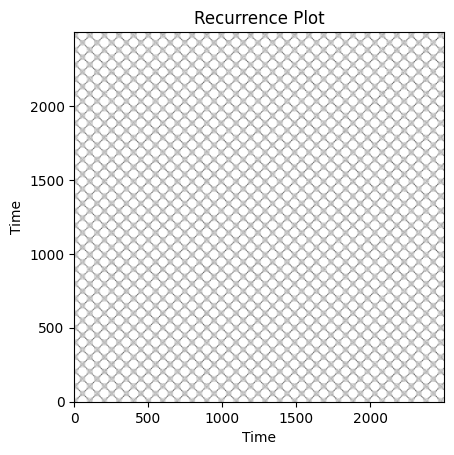

In [21]:
from pyts.image import RecurrencePlot
import matplotlib.pyplot as plt
true_data = data[select]['true_value']
# Sample trajectory: could be from your reservoir or true system
trajectory = true_data[:, 0]  # use one coordinate or do PCA first

# RP object
rp = RecurrencePlot(threshold='point', percentage=10)

# If using 1D: it will do embedding internally
X_rp = rp.fit_transform(trajectory.reshape(1, -1))

plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title("Recurrence Plot")
plt.xlabel("Time")
plt.ylabel("Time")
plt.show()
